In [116]:
# imports
import numpy as np
import pandas as pd
from scipy.stats import chi2, chi2_contingency, f_oneway
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import geopandas
from urllib.request import urlopen
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans

In [4]:
# read raw data
raw = pd.read_parquet("shoppingcarts.parquet", engine ='pyarrow')

In [39]:
# compute sales per county and product for later use
sales_per_county = raw.groupby("county")["product_id"].count().rename("Bestellungen pro County")
sales_per_product = raw.groupby("product_id")["order_id"].count().rename("Bestellungen pro Produkt")

## Frage 1
###  Prüfen Sie, ob es belastbare Unterschiede im Wiederbestellverhalten zwischen den Produkten mit den product_ids 6217, 14778 und 23579 gibt. 

In [35]:
raw

,order_id,product_id,add_to_cart_order,reordered,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle,county
0,1,17704,3,1,205970,5,17,12.0,Lemons,123,4,produce,packaged vegetables fruits,Ventura
1,1,17461,7,1,205970,5,17,12.0,Air Chilled Organic Boneless Skinless Chicken ...,35,12,meat seafood,poultry counter,Ventura
2,1,46667,6,1,205970,5,17,12.0,Organic Ginger Root,83,4,produce,fresh vegetables,Ventura
3,1,17668,5,1,205970,5,17,12.0,Unsweetened Chocolate Almond Breeze Almond Milk,91,16,dairy eggs,soy lactosefree,Ventura
4,1,33754,1,1,205970,5,17,12.0,Total 2% with Strawberry Lowfat Greek Strained...,120,16,dairy eggs,yogurt,Ventura
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6145743,604939,41950,4,0,52726,1,11,2.0,Organic Tomato Cluster,83,4,produce,fresh vegetables,Madera
6145744,604939,38061,9,0,52726,1,11,2.0,Organic Raw Coconut Butter,36,16,dairy eggs,butter,Madera
6145745,604939,10667,8,0,52726,1,11,2.0,Imported Butter,36,16,dairy eggs,butter,Madera
6145746,604939,18811,3,1,52726,1,11,2.0,Organic Apple Juice,98,7,beverages,juice nectars,Madera


In [34]:
# filter to 6217, 14778 & 23579
# count reorders, compute fraction of reorders and avg time until reorder
# rename columns
df_q1 = raw[raw.product_id.isin([6217, 14778, 23579])].groupby("product_id")\
        .agg({"product_name": pd.Series.mode, "order_id": "count", "reordered": "mean", "days_since_prior_order": "mean"})\
        .rename(columns={"product_name": "Bezeichnung", "order_id": "Anzahl Bestellungen", "reordered": "Anteil Wiederbestellungen", "days_since_prior_order": "durchschn. Zeit bis Wiederbestellung"})
df_q1.round(2)

,Bezeichnung,Anzahl Bestellungen,Anteil Wiederbestellungen,durchschn. Zeit bis Wiederbestellung
product_id,,,,
6217,Pumpkin Spice Protein Bar,46,0.46,10.13
14778,Organic Chocolate Chip Chewy Granola Bars,1329,0.62,11.43
23579,Peanut Butter Chocolate Chip Fruit & Nut Food Bar,1357,0.62,11.00


In [7]:
# Aggregate data to show absolute numbers of reordered yes/no per product
q1_1 = raw[raw.product_id.isin([6217, 14778, 23579])]
# Perform chi2 test for independency for all 3 Products
total = chi2_contingency(pd.crosstab(q1_1['product_id'],q1_1['reordered'], margins = False, normalize = False), correction=False)
#Perform chi2 test for the 3 possibilities of combination
# Chi2 test without Product 23579
q1_2 = q1_1[q1_1["product_id"] != 23579]
no23579 = chi2_contingency(pd.crosstab(q1_2['product_id'],q1_2['reordered'], margins = False, normalize = False), correction=False)
# Chi2 test without Product 14778
q1_3 = q1_1[q1_1["product_id"] != 14778]
no14778 = chi2_contingency(pd.crosstab(q1_3['product_id'],q1_3['reordered'], margins = False, normalize = False), correction=False)
# Chi2 test without Product 6217
q1_4 = q1_1[q1_1["product_id"] != 6217]
no6217 = chi2_contingency(pd.crosstab(q1_4['product_id'],q1_4['reordered'], margins = False, normalize = False), correction=False)
#Summarize results of analysis in final DataFrame
df_stats = pd.DataFrame([
    ["...allen 3 Produkten", *total],
    ["...6217 & 14778", *no23579],
    ["...6217 & 23579", *no14778],
    ["...14778 & 23579", *no6217]])
df_stats.columns = ["Abhängigkeit zwischen...", "Teststatistik χ²", "p-Wert", "Freiheitsgrade", "Signifikant"]
df_stats["Signifikant"] = df_stats["p-Wert"] < 0.05

In [8]:
# Basis for chi2 tests
pd.crosstab(q1_1['product_id'],q1_1['reordered'], margins = False, normalize = False)

reordered,0,1
product_id,,
6217,25,21
14778,506,823
23579,519,838


In [37]:
# results of chi2 tests
df_stats.round(2)

,Abhängigkeit zwischen...,Teststatistik χ²,p-Wert,Freiheitsgrade,Signifikant
0,...allen 3 Produkten,5.02,0.08,2,False
1,...6217 & 14778,4.97,0.03,1,True
2,...6217 & 23579,4.86,0.03,1,True
3,...14778 & 23579,0.01,0.93,1,False


Belastbarer Unterschied zwischen den Produkten:
- Product 6217 hebt sich im Kaufverhalten von Product 14778 & 23579 ab: deutlich geringere Anzahl absoluter Bestellungen (46) & geringerer Wiederbestellungsanteil (45.7%)
- Product 14778 & 23579 zeigen ähnliches Kaufverhalten: ähnliche Anzahl absoluter Bestellungen (1329,1357) & höherer Wiederbestellungsanteil (beide ca. 62 %)

Betrachtung von durchschn. Zeit bis Wiederbestellung schwierig, da starke Konfundierung mit restlichen Items im Warenkorb vorliegen sollte (damit ist der isolierte Vergleich der Wiederbestllungszeit zwischen den Produkten nicht ohne weiteres möglich)

## Frage 2
### Schwankt die Popularität von Produkt 9390 zwischen den Regionen?

In [78]:
# filter to 9390, group by county and count orders
# sort and rename
df_q2 = raw[raw.product_id == 9390].groupby("county").agg({"order_id": "count"})\
        .sort_values(by="order_id",ascending=False)\
        .rename(columns={"order_id": "Anzahl Bestellungen"})
# compute fraction of orders
df_q2["Anteil Bestellungen"] = df_q2["Anzahl Bestellungen"] / int(df_q2.sum())
# compute share of product per county
df_q2["Anteil Bestellungen in County"] = df_q2["Anzahl Bestellungen"] / sales_per_county

In [81]:
df_q2 = df_q2.sort_values(by='Anteil Bestellungen', ascending = False).reset_index()

- 16 Counties ohne existente Nachfrage (1 oder 0 Verkäufe)
- Danach monotoner Anstieg zur Spitzengruppe (17 Counties mit > 20 Käufen)

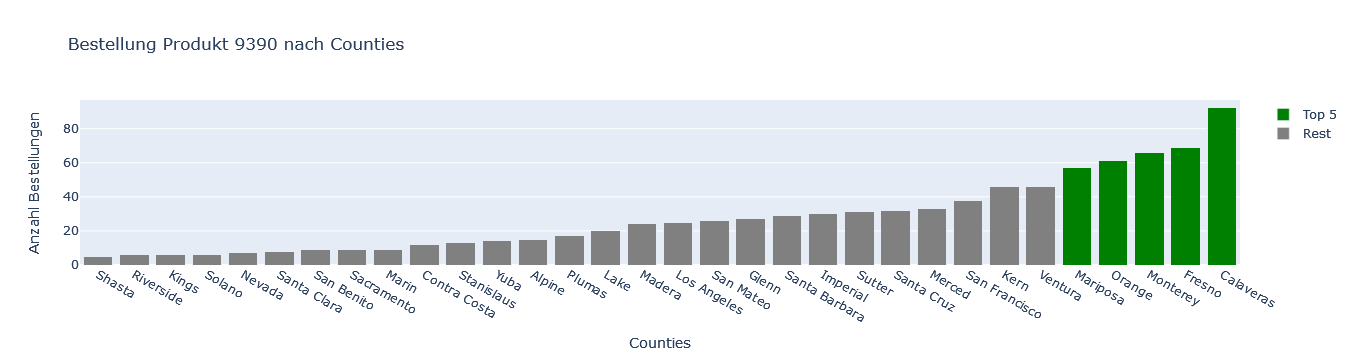

In [68]:
# Order counties by most purchases of product
df_q2 = df_q2.sort_values(by='Anteil Bestellungen', ascending = False).reset_index()
bins = [0,50,100] # define 2 bins for Top 5 yes/no (only 5 Counties have more than 50 orders)
labels = ['Rest', 'Top 5']
colors = {'Rest':'gray','Top 5':'green'}
df_q2['label'] = pd.cut(df_q2['Anzahl Bestellungen'], bins=bins, labels=labels) # generate label for Top 5 yes/no
df_q2=df_q2[df_q2["Anzahl Bestellungen"]>=5] # for better visibility in plot: remove all counties with less than 5 purchases
bars = []
for label, label_df in df_q2.groupby('label'): 
    bars.append(go.Bar(x=label_df.county, # for each county
                       y=label_df['Anzahl Bestellungen'], # append count orders
                       name=label, # name it Top 5 / Rest
                       marker={'color':colors[label]})) # set color of Bar


my_layout = ({"title": "Bestellung Produkt 9390 nach Counties",
              "yaxis": {"title":"Anzahl Bestellungen"},
              "xaxis": {"title":"Counties"},
              "showlegend": True})
fig = go.FigureWidget(data=bars, layout = my_layout)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})
fig.show()

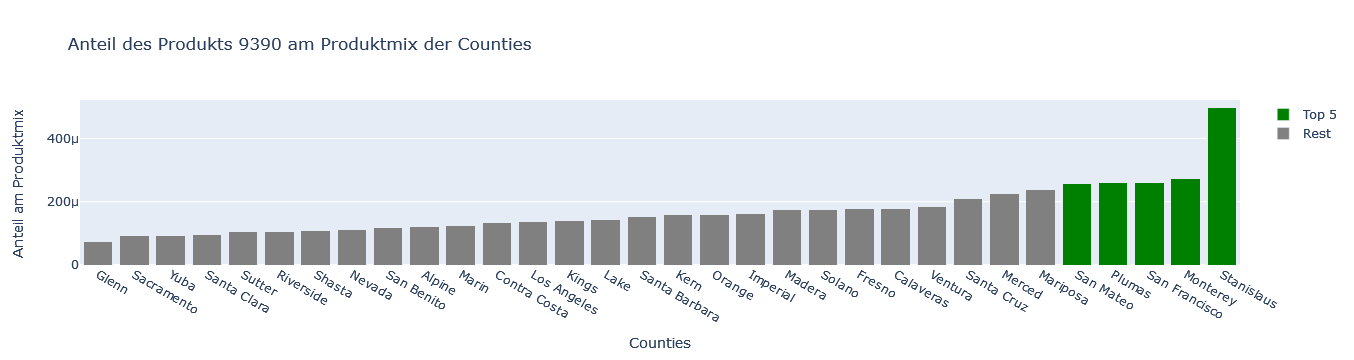

In [69]:
# Second analysis: Order counties by highest product share in given county
df_q2 = df_q2.sort_values(by='Anteil Bestellungen in County', ascending = False)
bins = [0,0.00024,1] # define 2 bins for Top 5 yes/no
labels = ['Rest', 'Top 5']
colors = {'Rest':'gray','Top 5':'green'}
df_q2['label'] = pd.cut(df_q2['Anteil Bestellungen in County'], bins=bins, labels=labels) # generate label for Top 5 yes/no
df_q2=df_q2[df_q2["Anzahl Bestellungen"]>0.007535] # for better visibility in plot: remove all counties with small product share
bars = []
for label, label_df in df_q2.groupby('label'):
    bars.append(go.Bar(x=label_df.county, # for each county
                       y=label_df['Anteil Bestellungen in County'], # append count orders
                       name=label, # name it Top 5 / Rest
                       marker={'color':colors[label]})) # set color of Bar
my_layout = ({"title": "Anteil des Produkts 9390 am Produktmix der Counties",
                       "yaxis": {"title":"Anteil am Produktmix"},
                       "xaxis": {"title":"Counties"},
                       "showlegend": True})
fig = go.FigureWidget(data=bars, layout = my_layout)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})
fig.show()

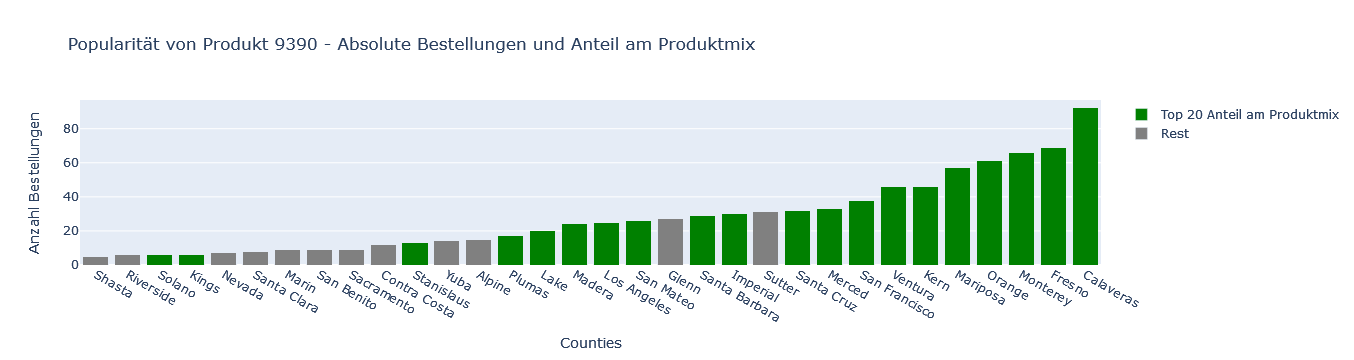

In [70]:
# combine both information in one graph
bins = [0,0.000136,1] # in order to achive combination: Bins represent 20 Counties with largest product share
labels = ['Rest', 'Top 20 Anteil am Produktmix']
colors = {'Rest':'gray','Top 20 Anteil am Produktmix':'green'}
df_q2['label'] = pd.cut(df_q2['Anteil Bestellungen in County'], bins=bins, labels=labels) # generate label for Top 20 yes/no
df_q2=df_q2[df_q2["Anzahl Bestellungen"]>=5] # for better visibility in plot: remove all counties with less than 5 purchases
bars = []
for label, label_df in df_q2.groupby('label'):
    bars.append(go.Bar(x=label_df.county, # for each county
                       y=label_df['Anzahl Bestellungen'], # append count orders
                       name=label, # name it Top 5 / Rest
                       marker={'color':colors[label]})) # set color of Bar
my_layout = ({"title": "Popularität von Produkt 9390 - Absolute Bestellungen und Anteil am Produktmix",
              "yaxis": {"title":"Anzahl Bestellungen"},
              "xaxis": {"title":"Counties"},
              "showlegend": True})
fig = go.FigureWidget(data=bars, layout = my_layout)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})
fig.show()

## Frage 3
### Sind die Produkte 9390, 2713, 21883 und 16753 in den gleichen Regionen populär und unpopulär, oder unterscheiden sich die Muster?

In [86]:
# filter to 9390, 2713, 21883 & 16753, group by county and product id and count orders
# rename column
df_q3 = raw[raw.product_id.isin([9390, 2713, 21883, 16753])].groupby(["county","product_id"]).agg({"order_id": "count"})\
        .rename(columns={"order_id": "Anzahl Bestellungen"})
# join sales per product
df_q3 = df_q3.merge(sales_per_product, left_index=True, right_index=True)
# compute fraction/relative measure
df_q3["Anteil Bestellungen"] = df_q3["Anzahl Bestellungen"] / df_q3["Bestellungen pro Produkt"]
df_q3 = df_q3.sort_values(by=["product_id","Anteil Bestellungen"],ascending=False).reset_index()

In [87]:
# load geodata from california counties
with urlopen('https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/california-counties.geojson') as response:
    california_geojson = geopandas.read_file(response)

In [88]:
np.sort(raw.county.unique()) == np.sort(california_geojson.name.unique())

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

Countybezeichnungen stimmen in Geodaten mit Angaben im Analysedatansatz überein!

In [96]:
# load geojson data
geopd = california_geojson[['name','geometry']]
# merge Original Data with geojson data
df_q3g = pd.merge(geopd,df_q3,how='outer',left_on='name',right_on='county').drop('county',axis=1).rename(columns={'geometry':'Koordinaten', 'name':'county'})
# Transform generic DataFrame to GeoDataFrame
df_q3g = geopandas.GeoDataFrame(df_q3g,geometry='Koordinaten')

In [97]:
def pipe(df,ids):
    '''Returns a DataFrame that holds GeoData for each county, aswell as the
    relative product popularity for given product (ids)
    '''
    df = df[df.product_id==ids] # only take values from given product
    fil = np.sort(df.county.unique()) # list of counties where given product was bought
    geo = np.sort(california_geojson.name.unique()) # list of all counties in california
    match = []
    unique = []
    for el in geo:
        if el in fil:
            match.append(el) 
        else:
            unique.append(el) # counties that dont hold values
    for el in unique: # for visualization purposes: counties witouht values need an aritificial row with 0 orders
        new_row = {'county':el, 'Koordinaten':california_geojson[california_geojson.name==el]['geometry'].values[0], 'product_id':0, 
                   'Anzahl Bestellungen':0,
                   'Bestellungen pro Produkt':0,
                   'Anteil Bestellungen':0}
        df = df.append(new_row, ignore_index=True)
        df.Koordinaten = df.Koordinaten.astype('geometry')
    return df

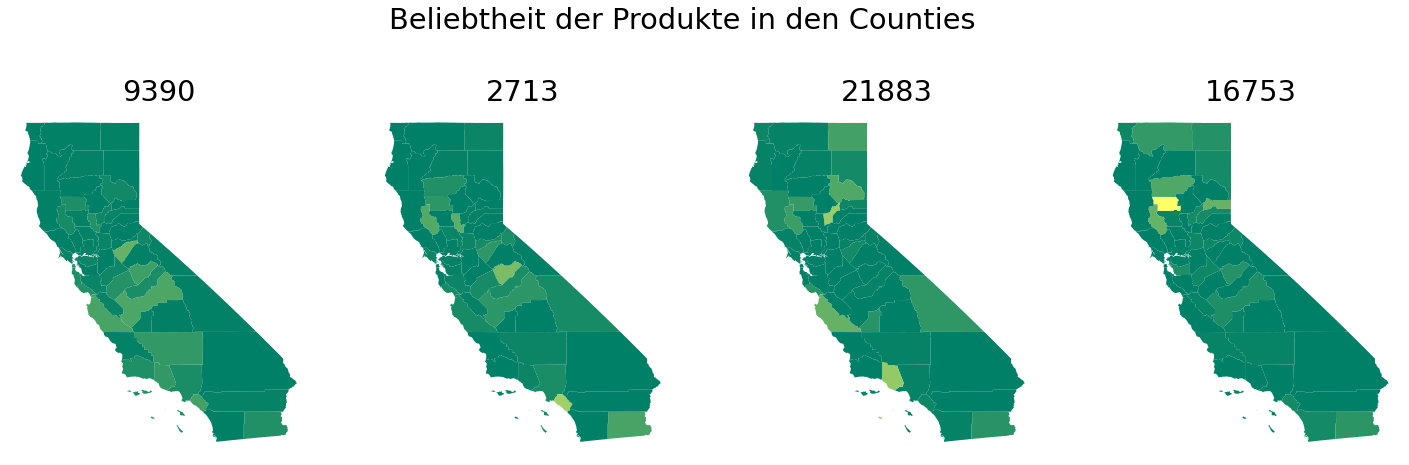

In [111]:
# generate geoplot for popularity of products in each county
cmap = 'summer'
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4, sharex=True, sharey=True)
fig.suptitle('Beliebtheit der Produkte in den Counties')
pipe(df_q3g, 9390).plot(ax = ax1,column='Anteil Bestellungen',cmap=cmap,vmin=0,vmax=0.25)
pipe(df_q3g, 2713).plot(ax =ax2,column='Anteil Bestellungen',cmap=cmap,vmin=0,vmax=0.25)
pipe(df_q3g, 21883).plot(ax =ax3,column='Anteil Bestellungen',cmap=cmap,vmin=0,vmax=0.25)
pipe(df_q3g, 16753).plot(ax =ax4,column='Anteil Bestellungen',cmap=cmap,vmin=0,vmax=0.25)
ax1.set_title('9390')
ax1.axis('off')
ax2.set_title('2713')
ax2.axis('off')
ax3.set_title('21883')
ax3.axis('off')
ax4.set_title('16753')
ax4.axis('off')
fig.set_size_inches(25, 8)
plt.rcParams.update({'font.size': 24})

Effizienter als Erzeugen über Plotly: Legende aus unterern tabelle croppen und Einfügen

In [114]:
# generate DataFrames for visualization of Top5 Counties per Product
df_9390=pipe(df_q3g, 9390)
df_2713=pipe(df_q3g, 2713)
df_21883=pipe(df_q3g, 21883)
df_16753=pipe(df_q3g, 16753)
df_9390_t5 = df_9390.sort_values('Anteil Bestellungen',ascending=False)[['county','Anzahl Bestellungen','Anteil Bestellungen']].head(5)
df_2713_t5= df_2713.sort_values('Anteil Bestellungen',ascending=False)[['county','Anzahl Bestellungen','Anteil Bestellungen']].head(5)
df_21883_t5 = df_21883.sort_values('Anteil Bestellungen',ascending=False)[['county','Anzahl Bestellungen','Anteil Bestellungen']].head(5)
df_16753_t5 = df_16753.sort_values('Anteil Bestellungen',ascending=False)[['county','Anzahl Bestellungen','Anteil Bestellungen']].head(5)

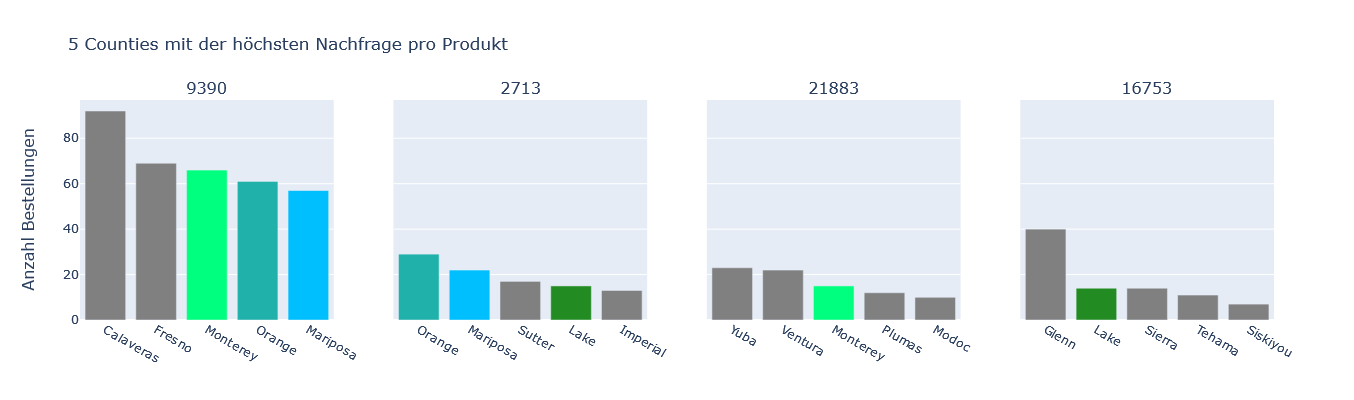

In [122]:
# Generate 4 Barcharts for Top 5 Counties per Product
# Colors represent cooccurence of counties
colors1=['grey']*5
colors2=['grey']*5
colors3=['grey']*5
colors4=['grey']*5
colors1[2]='springgreen'
colors1[3]='lightseagreen'
colors1[4]='deepskyblue'
colors2[0]='lightseagreen'
colors2[1]='deepskyblue'
colors2[3]='forestgreen'
colors3[2]='springgreen'
colors4[1]='forestgreen'
fig = make_subplots(rows=1,
                    cols=4,
                    shared_yaxes='all',
                    y_title = 'Anzahl Bestellungen',
                    subplot_titles = ['9390','2713','21883','16753'])

fig.add_trace(
    go.Bar(x=df_9390_t5.county, y=df_9390_t5['Anzahl Bestellungen'], name = '9390',marker_color=colors1),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=df_2713_t5.county, y=df_2713_t5['Anzahl Bestellungen'], name = '2713',marker_color=colors2),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=df_21883_t5.county, y=df_21883_t5['Anzahl Bestellungen'], name = '21883',marker_color=colors3),
    row=1, col=3
)

fig.add_trace(
    go.Bar(x=df_16753_t5.county, y=df_16753_t5['Anzahl Bestellungen'], name = '16753',marker_color=colors4),
    row=1, col=4
)
fig.update_layout(height=400, width=1200,
                  title_text="5 Counties mit der höchsten Nachfrage pro Produkt",
                  showlegend=False)

fig.show()

In [37]:
# helplist to identify similarities in top 5 counties
simil = df_9390_t5.county.tolist() + df_2713_t5.county.tolist() + df_21883_t5.county.tolist() + df_16753_t5.county.tolist()
print(simil.sort())

## Frage 4
### Welche Counties sind sich ähnlich in Hinblick auf den Produktmix?

In [217]:
# group by county and department and count orders
# pivot to reshape from long to wide
df_q4 = raw.groupby(["county", "department"], as_index=False)[["order_id"]].count()\
        .pivot(index="county", columns="department", values="order_id")

In [218]:
# Drop Counties with low product numbers, missing information doesnt allow to deduce product mix
# Drop: Count Products < 1000: Trinity, San Bernardino, Placer, Butte
df_q4.drop(['Trinity','San Bernardino','Placer','Butte'],axis=0,inplace=True)

In [219]:
# Compute Share of Categories in County
df_q4 = df_q4.fillna(0)
df_q4['sum'] = df_q4.sum(axis=1)
for el in df_q4.columns:
    df_q4[f'{el}_r'] = df_q4[el]/df_q4['sum']
df_q4_1 = df_q4.loc[:,'alcohol_r':'snacks_r']

In [220]:
# Generate DataFrame with data to perform Clusteranalysis on
df_cluster = df_q4.loc[:,'alcohol_r':'snacks_r'].fillna(0)
# get different cluster solutions
cluster = [3,4,5,15]
X = df_cluster
for el in cluster:
    # Let algorithm separate cases into cluster
    kmeans = KMeans(n_clusters=el, random_state=0).fit(X)
    # append new Column with Cluster Labeling
    df_cluster[f"{el}-Cluster Lösung"] = kmeans.labels_

In [221]:
# Compare cluster solutions:

# get cagetory mean
# remove other cluster solutions
# get variance to evaluate cluster-relevance of each category
# sort cluster_relevance
# Calculate sum to compare Models
print(df_cluster.groupby('5-Cluster Lösung').mean()\
                                      .drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)\
                                      .std(axis=0)\
                                      .sort_values(ascending=False)\
                                      .sum())
print(df_cluster.groupby('4-Cluster Lösung').mean().drop(['3-Cluster Lösung','5-Cluster Lösung','15-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())
print(df_cluster.groupby('3-Cluster Lösung').mean().drop(['5-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())
print(df_cluster.groupby('15-Cluster Lösung').mean().drop(['5-Cluster Lösung','4-Cluster Lösung','3-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())

0.2308853526942269
0.18686876805207264
0.18376598375349035
0.24517171826674858


Erkenntnis: Cluster 5 differenziert deutlich stärker zwischen den Daten, 3/4 Cluster kaum Unterschied. Analysen auf 5 Cluster fortführen (15 zu unübersichtlich/aufwändig)

In [222]:
# Calculate cluster deviation for each department
df_cluster.groupby('5-Cluster Lösung').mean()\
                                      .drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)\
                                      .std(axis=0)\
                                      .sort_values(ascending=False)

department
produce_r            0.075904
beverages_r          0.035838
snacks_r             0.023042
pantry_r             0.013052
alcohol_r            0.011876
household_r          0.011546
dairy eggs_r         0.008284
bakery_r             0.007777
frozen_r             0.007024
canned goods_r       0.006537
dry goods pasta_r    0.004851
breakfast_r          0.004498
meat seafood_r       0.004387
personal care_r      0.003732
deli_r               0.003426
babies_r             0.002993
pets_r               0.002468
international_r      0.001579
bulk_r               0.001107
other_r              0.000667
missing_r            0.000295
dtype: float64

Departments mit der größten Standardabweichung sind für die größte Differenzierung zwischen den Clustern zuständig -> diese Departments machen also die größten Unterschiede im Produktmix aus

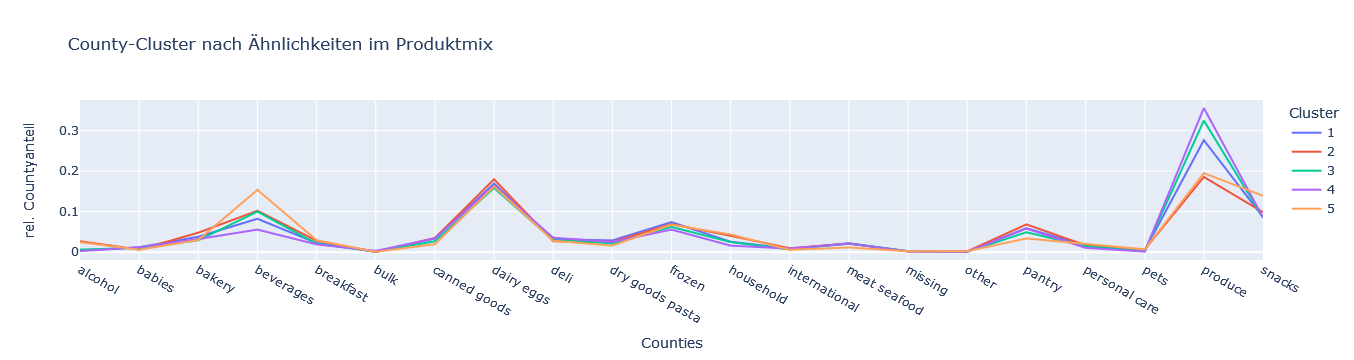

In [223]:
# plot cluster deviation
x = df_cluster.groupby('5-Cluster Lösung').mean().drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)
x.columns = [el[:-2] for el in x.columns]
y = [x.iloc[row] for row in range(len(x))]
fig = px.line(x=x.columns,
              y=y,
              title = 'County-Cluster nach Ähnlichkeiten im Produktmix',
              labels ={'variable':'Cluster',
                       'value':'rel. Countyanteil',
                       'x':'Counties'})
newnames = {'wide_variable_0':'1', 'wide_variable_1':'2','wide_variable_2':'3','wide_variable_3':'4','wide_variable_4':'5'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))               
fig.show()

In [224]:
# deduced from deviation table abvobe as well as visualization: show departments with highest cluster differntiation
x[['produce','beverages','snacks','pantry','alcohol']]

,produce,beverages,snacks,pantry,alcohol
5-Cluster Lösung,,,,,
0,0.275975,0.082335,0.086486,0.059097,0.004143
1,0.185513,0.102155,0.098616,0.068503,0.027057
2,0.324526,0.100056,0.084987,0.049208,0.006380
3,0.355378,0.055653,0.085648,0.058284,0.002733
4,0.194849,0.153499,0.138905,0.033899,0.024785


In [225]:
# Check all counties with high deviation in between clusters for sign.
F_test = df_cluster[['produce_r','beverages_r','snacks_r','pantry_r','alcohol_r','5-Cluster Lösung']]
result = []
for el in range(len(F_test.columns[:-1])): # loop for every county in dataframe
    col = F_test[F_test.columns[[el,5]]] # chose the county and column for Cluster labeling
    result.append(f_oneway(*[col[col["5-Cluster Lösung"]==cluster].iloc[:,0] for cluster in range(0,4)])) # Perform F-Test
result

[F_onewayResult(statistic=110.02575373974743, pvalue=2.919835546459455e-21),
 F_onewayResult(statistic=9.750031372471103, pvalue=4.092885948562369e-05),
 F_onewayResult(statistic=0.5503785730454995, pvalue=0.6503865209887911),
 F_onewayResult(statistic=6.987507404771007, pvalue=0.0005547021474864494),
 F_onewayResult(statistic=35.017824336289145, pvalue=4.850971761390978e-12)]

Alle signifikant, außer 4. F-Test = "Pantry"

Schlussfolgerung: Die Cluster differenzieren am besten Anhand von Produce, beverages, snacks und alcohol

In [226]:
print("Counties der Cluster:\n")
for el in range (0,5):
    print('Größe des Clusters: ',len(df_cluster[df_cluster['5-Cluster Lösung']==el].index))
    print(df_cluster[df_cluster['5-Cluster Lösung']==el].index,"\n")

Counties der Cluster:

Größe des Clusters:  27
Index(['Alpine', 'Calaveras', 'Contra Costa', 'Glenn', 'Imperial', 'Kings',
       'Lake', 'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Merced', 'Mono',
       'Monterey', 'Nevada', 'Orange', 'Riverside', 'San Benito',
       'San Joaquin', 'San Luis Obispo', 'Santa Clara', 'Shasta', 'Solano',
       'Stanislaus', 'Tulare', 'Tuolumne', 'Ventura'],
      dtype='object', name='county') 

Größe des Clusters:  6
Index(['Del Norte', 'Lassen', 'Modoc', 'San Diego', 'Sierra', 'Tehama'], dtype='object', name='county') 

Größe des Clusters:  10
Index(['Alameda', 'El Dorado', 'Inyo', 'Kern', 'Mendocino', 'Plumas',
       'Santa Cruz', 'Siskiyou', 'Sonoma', 'Sutter'],
      dtype='object', name='county') 

Größe des Clusters:  8
Index(['Amador', 'Colusa', 'Fresno', 'Sacramento', 'San Francisco',
       'San Mateo', 'Santa Barbara', 'Yolo'],
      dtype='object', name='county') 

Größe des Clusters:  3
Index(['Humboldt', 'Napa', 'Yuba'], dtype='obje

## Frage 5
### Welche der TOP 50-Produkte sind sich ähnlich in Hinblick auf die regionale Verteilung?

In [186]:
# compute top 50 products
top50 = sales_per_product.sort_values().tail(50).index
# filter to top 50 products, group by product and county and count orders
# pivot to reshape from long to wide
df_q5 = raw[raw["product_id"].isin(top50)].groupby(["product_id", "county"], as_index=False)[["order_id"]].count()\
        .pivot(index="product_id", columns="county", values="order_id")
df_q5_1=df_q5.fillna(0)
df_q5_1['sum'] = df_q5_1.sum(axis=1)
# Drop Counties with low product numbers, missing information doesnt allow to deduce product mix
# Drop: Count Products < 1000: Trinity, San Bernardino, Placer, Santa Barbara
df_q5_1.drop(['Trinity','San Bernardino','Placer','Santa Barbara'],axis=1,inplace=True)
# Compute Share of Counties in product
for el in df_q5_1.columns:
    df_q5_1[f'{el}_r'] = df_q5_1[el]/df_q5_1['sum']
df_q5_1 = df_q5_1.loc[:,'Alameda_r':'Yuba_r']

In [187]:
# get different cluster solutions
cluster = [3,4,5,15]
X = df_q5_1
for el in cluster:
    # Let algorithm separate cases into cluster
    kmeans = KMeans(n_clusters=el, random_state=0).fit(X)
    # append new Column with Cluster Labeling
    df_q5_1[f"{el}-Cluster Lösung"] = kmeans.labels_

In [188]:
# get cagetory mean
# remove other cluster solutions
# get variance to evaluate cluster-relevance of each category
# sort cluster_relevance
# Calculate sum to compare Models
df_cluster = df_q5_1
print(df_cluster.groupby('5-Cluster Lösung').mean()\
                                      .drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)\
                                      .std(axis=0)\
                                      .sort_values(ascending=False)\
                                      .sum())
print(df_cluster.groupby('4-Cluster Lösung').mean().drop(['3-Cluster Lösung','5-Cluster Lösung','15-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())
print(df_cluster.groupby('3-Cluster Lösung').mean().drop(['5-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())
print(df_cluster.groupby('15-Cluster Lösung').mean().drop(['5-Cluster Lösung','4-Cluster Lösung','3-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())

0.16513286459154125
0.1671662021673932
0.1708239530451069
0.23000121566136375


Selbe Argumentation wie in Frage 4 für 5-Cluster Lösung

In [189]:
df_cluster.groupby('5-Cluster Lösung').mean()\
                                      .drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)\
                                      .std(axis=0)\
                                      .sort_values(ascending=False)


county
Fresno_r             0.013352
Kern_r               0.013006
San Francisco_r      0.012248
Yuba_r               0.008961
Orange_r             0.006194
San Mateo_r          0.005888
Sacramento_r         0.005710
Madera_r             0.005541
Sutter_r             0.005256
Lake_r               0.005036
Los Angeles_r        0.004843
Calaveras_r          0.004748
Amador_r             0.004384
Ventura_r            0.003731
Nevada_r             0.003634
Glenn_r              0.003472
Mendocino_r          0.003410
Modoc_r              0.003184
Mariposa_r           0.003119
Monterey_r           0.003028
Merced_r             0.003011
Stanislaus_r         0.002819
Santa Cruz_r         0.002784
Santa Clara_r        0.002705
Alpine_r             0.002377
Marin_r              0.002228
San Benito_r         0.001813
Plumas_r             0.001730
Imperial_r           0.001729
Lassen_r             0.001674
Riverside_r          0.001579
Inyo_r               0.001423
Solano_r             0.001358
Nap

Couties mit der größten Standardabweichung sind für die größte Differenzierung zwischen den Clustern zuständig -> diese Counties machen also die größten Unterschiede in der Ähnlichkeitsstruktur der Produkte aus

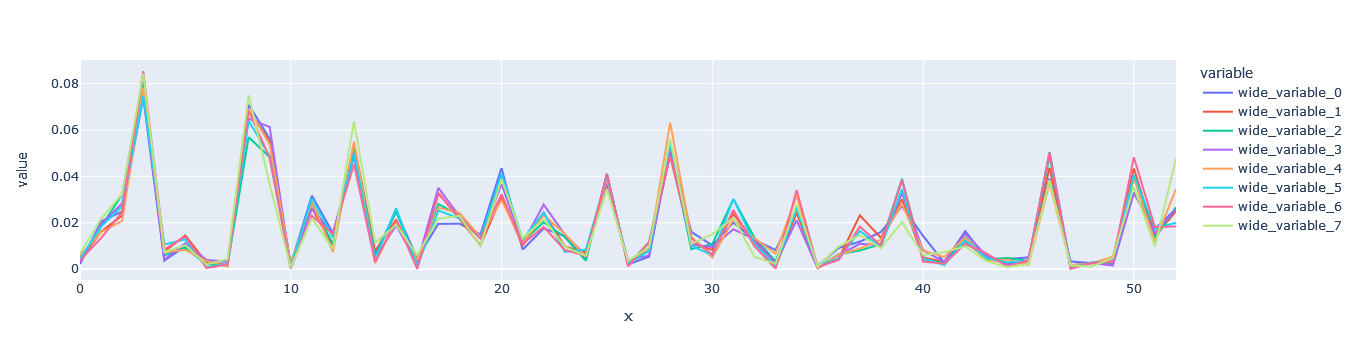

In [190]:
# Evaluate Clusters
x1 = df_cluster[df_cluster['5-Cluster Lösung']==0].loc[:,:'Yuba_r']
y = [x1.iloc[row] for row in range(len(x1))]
fig = px.line(x=np.arange(x1.shape[1]),y=y)
fig.show()

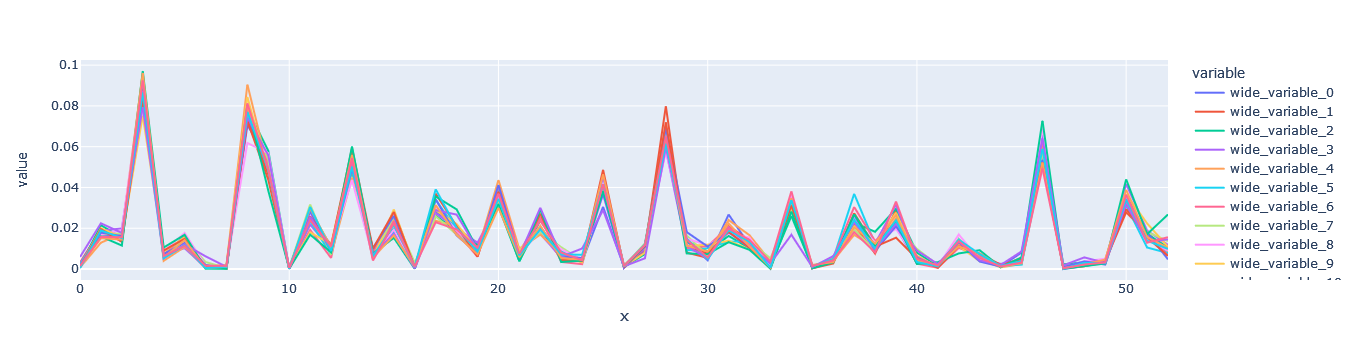

In [191]:
# Evaluate Clusters
x1 = df_cluster[df_cluster['5-Cluster Lösung']==1].loc[:,:'Yuba_r']
y = [x1.iloc[row] for row in range(len(x1))]
fig = px.line(x=np.arange(x1.shape[1]), y=y)
fig.show()

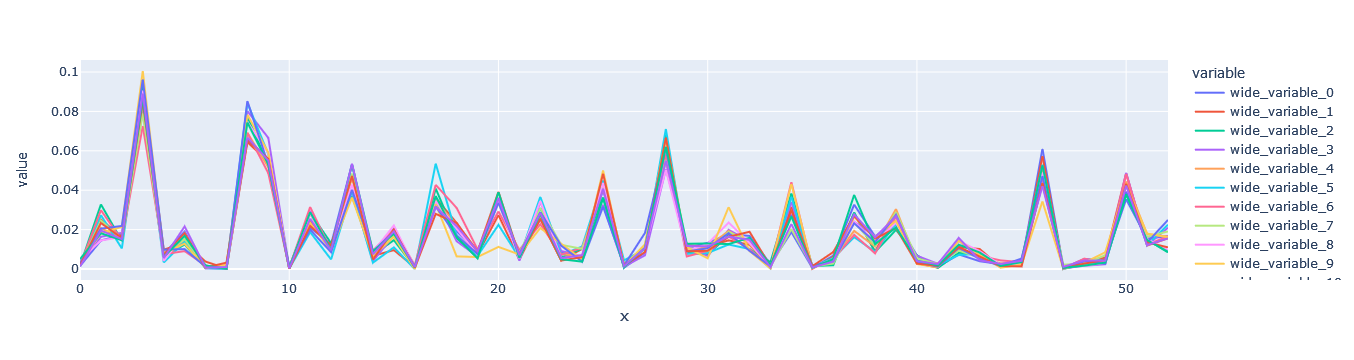

In [192]:
# Evaluate Clusters
x1 = df_cluster[df_cluster['5-Cluster Lösung']==2].loc[:,:'Yuba_r']
y = [x1.iloc[row] for row in range(len(x1))]
fig = px.line(x=np.arange(x1.shape[1]), y=y)
fig.show()

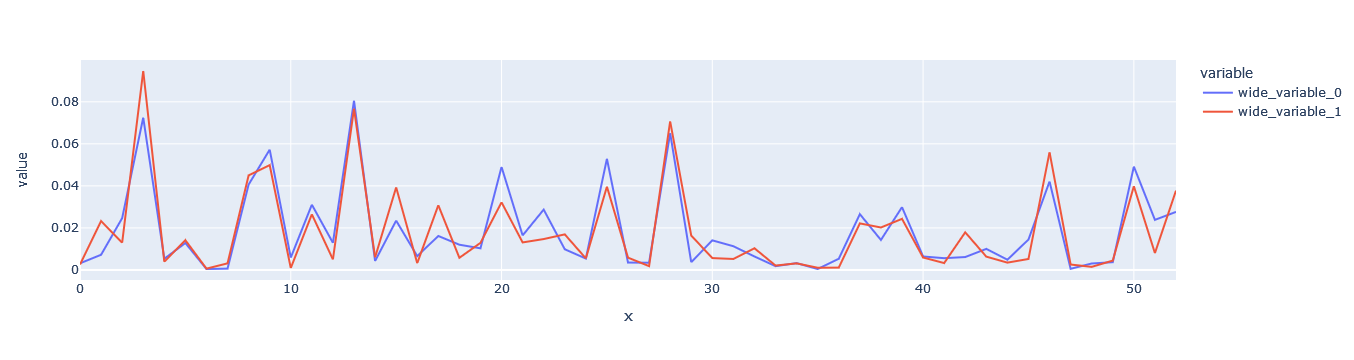

In [193]:
# Evaluate Clusters
x1 = df_cluster[df_cluster['5-Cluster Lösung']==3].loc[:,:'Yuba_r']
y = [x1.iloc[row] for row in range(len(x1))]
fig = px.line(x=np.arange(x1.shape[1]), y=y)
fig.show()

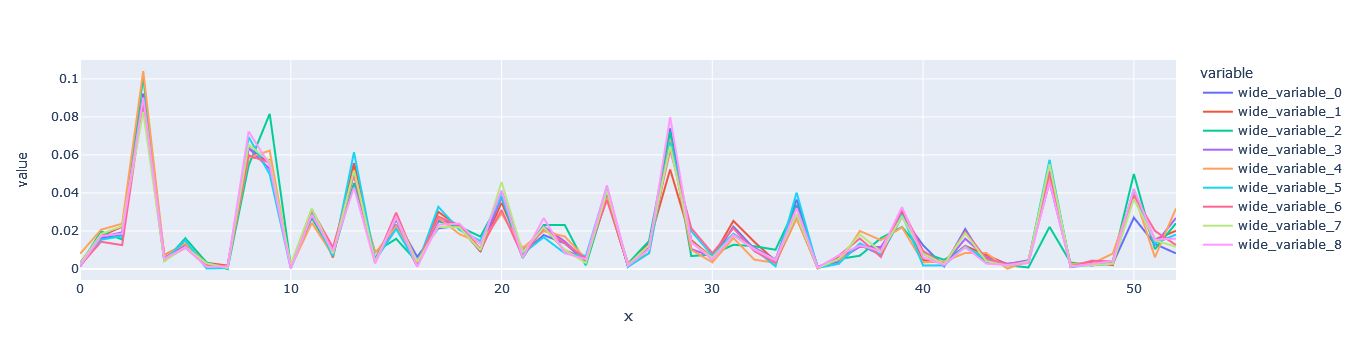

In [194]:
x1 = df_cluster[df_cluster['5-Cluster Lösung']==4].loc[:,:'Yuba_r']
y = [x1.iloc[row] for row in range(len(x1))]
fig = px.line(x=np.arange(x1.shape[1]), y=y)
fig.show()

Ergebnis der Evaluation: Cluster 1,2,4 finden sehr gute Ähnlichkeitsstrukturen, Cluster 0 und 3 sind problematisch, da nur 1 bzw. 2 PRodukte zusammengefasst wurden

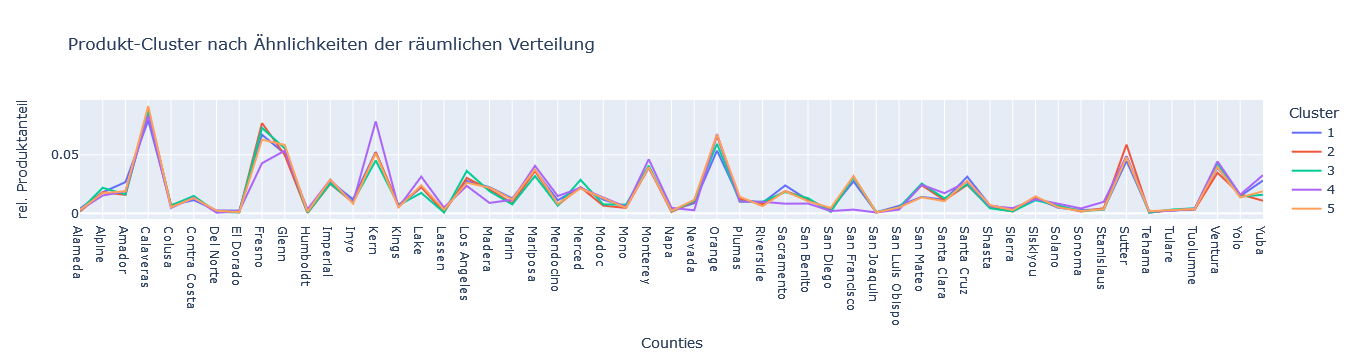

In [195]:
# plot cluster deviation
x = df_cluster.groupby('5-Cluster Lösung').mean().drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)
x.columns = [el[:-2] for el in x.columns]
y = [x.iloc[row] for row in range(len(x))]
fig = px.line(x=x.columns,
              y=y, 
              title = 'Produkt-Cluster nach Ähnlichkeiten der räumlichen Verteilung',
              labels ={'variable':'Cluster',
                       'value':'rel. Produktanteil',
                       'x':'Counties'})
newnames = {'wide_variable_0':'1', 'wide_variable_1':'2','wide_variable_2':'3','wide_variable_3':'4','wide_variable_4':'5'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))               
fig.show()

In [197]:
# Take Counties with highest differentiation of clusters and perform F-Tests
df_cluster[['Fresno_r','Kern_r','San Francisco_r','Yuba_r','Orange_r','San Mateo_r','Madera_r','Sacramento_r','Sutter_r','Lake_r','5-Cluster Lösung']]

county,Fresno_r,Kern_r,San Francisco_r,Yuba_r,Orange_r,San Mateo_r,Madera_r,Sacramento_r,Sutter_r,Lake_r,5-Cluster Lösung
product_id,,,,,,,,,,,
4605,0.063661,0.055730,0.036582,0.008217,0.074021,0.012718,0.022721,0.022292,0.051372,0.025865,4
4920,0.059029,0.055293,0.026899,0.020112,0.052366,0.011955,0.022105,0.025280,0.055479,0.023288,4
5077,0.054415,0.045244,0.033715,0.024107,0.072233,0.006988,0.022273,0.012752,0.022185,0.015897,4
5876,0.065663,0.053176,0.018761,0.016670,0.055088,0.032682,0.019239,0.017685,0.061003,0.020494,2
8277,0.064435,0.047136,0.031528,0.015607,0.057290,0.028143,0.023380,0.014542,0.057290,0.009590,2
8518,0.070479,0.050618,0.034312,0.007264,0.066383,0.024498,0.020788,0.026739,0.065765,0.025425,1
9076,0.070973,0.048580,0.026649,0.026002,0.053299,0.011844,0.019617,0.020080,0.039141,0.024891,0
10749,0.077233,0.037013,0.038388,0.008429,0.068071,0.028768,0.015758,0.017041,0.052955,0.014659,2
13176,0.068092,0.054130,0.024308,0.025045,0.048914,0.023189,0.021729,0.023812,0.043797,0.021516,0


Are these differences significant?

F- Test drauf performen!

In [204]:
F_test.columns[[10]]

Index(['5-Cluster Lösung'], dtype='object', name='county')

In [205]:
# Alle Counties, die Auffalligkeiten im Plot erkennen lassen, werden auf Signifikanz geprüft
F_test = df_cluster[['Fresno_r','Kern_r','San Francisco_r','Yuba_r','Orange_r','San Mateo_r','Madera_r','Sacramento_r','Sutter_r','Lake_r','5-Cluster Lösung']]
# Cluster 3 kann nicht aufgenommen werden, da nur 2 Produkte im Cluster
F_test = F_test[F_test['5-Cluster Lösung']!=3]
# Rename Cluster 4 zu 3, damit range Funktion funktioniert
F_test = F_test.replace(4,3)
result = []
for el in range(len(F_test.columns[:-1])): # Performe F-Tests für alle auffälligen Counties
    col = F_test[F_test.columns[[el,10]]] # Wähle nur jeweiliges County und Column der Clusterzuordnung
    result.append(f_oneway(*[col[col["5-Cluster Lösung"]==cluster].iloc[:,0] for cluster in range(0,4)])) # Performe F-Test
result

[F_onewayResult(statistic=11.743856866030617, pvalue=8.841537065730754e-06),
 F_onewayResult(statistic=5.463528708873992, pvalue=0.0027917242812086056),
 F_onewayResult(statistic=1.0897259611953456, pvalue=0.3634344560952048),
 F_onewayResult(statistic=13.45229629334432, pvalue=2.3020916192006504e-06),
 F_onewayResult(statistic=10.669196315169012, pvalue=2.151376835082071e-05),
 F_onewayResult(statistic=17.05309243056483, pvalue=1.7145035492111668e-07),
 F_onewayResult(statistic=1.9517751356434543, pvalue=0.1351868969286699),
 F_onewayResult(statistic=3.474042022940866, pvalue=0.02379339299336615),
 F_onewayResult(statistic=9.031622155003356, pvalue=8.945597577929087e-05),
 F_onewayResult(statistic=6.905898125371005, pvalue=0.0006545065604420033)]

Nicht Signifikante Unterschiede: F-Test Nummer 3,7 := San Francisco, Madera

In [207]:
# Signifikante Differenzierung der Cluster erfolgt anhand folgender Counties
F_test.drop(columns=['San Francisco_r','Madera_r']).columns

Index(['Fresno_r', 'Kern_r', 'Yuba_r', 'Orange_r', 'San Mateo_r',
       'Sacramento_r', 'Sutter_r', 'Lake_r', '5-Cluster Lösung'],
      dtype='object', name='county')

In [216]:
print("Produkte der Cluster:\n")
for el in range (0,5):
    print('Größe des Clusters: ',len(df_cluster[df_cluster['5-Cluster Lösung']==el].index))
    print(df_cluster[df_cluster['5-Cluster Lösung']==el].index,"\n")

Produkte der Cluster:

Größe des Clusters:  8
Int64Index([9076, 13176, 16797, 26604, 28204, 39275, 42265, 49235], dtype='int64', name='product_id') 

Größe des Clusters:  17
Int64Index([ 8518, 17794, 21616, 21903, 21938, 22935, 24964, 26209, 27104,
            28985, 31717, 34126, 35951, 39877, 40706, 45007, 47766],
           dtype='int64', name='product_id') 

Größe des Clusters:  14
Int64Index([ 5876,  8277, 10749, 19057, 21137, 22035, 27845, 27966, 30391,
            30489, 37646, 41950, 44359, 47209],
           dtype='int64', name='product_id') 

Größe des Clusters:  2
Int64Index([19660, 44632], dtype='int64', name='product_id') 

Größe des Clusters:  9
Int64Index([4605, 4920, 5077, 24852, 27086, 45066, 46979, 47626, 49683], dtype='int64', name='product_id') 

